# Analyze Genome Taxonomy Database r214

This notebook analyzes predicted conditions for all representative species in the Genome Taxonomy Database

In [1]:
import pandas as pd
from glob import glob
from collections import Counter

from matplotlib.colors import LinearSegmentedColormap
import string
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../")
from genome_spot.helpers import rename_condition_to_variable
plt.rcParams['svg.fonttype'] = 'none'

plt.style.use('project.mplstyle')

In [2]:
plot_formats = {
    'oxygen' : 'Oxygen',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
}
units = {
    'temperature' : u'\N{DEGREE SIGN}C',
    'ph' : 'pH',
    'salinity' : '% w/v NaCl',
    'oxygen' : 'Probability Oxygen Tolerant'
}


In [3]:
targets = ['oxygen', 'temperature_optimum', 'salinity_optimum', 'ph_optimum']

bin_definitions = {
    'oxygen' : [0, 0.5],
    'ph_optimum' : np.arange(3,12,1),
    'temperature_optimum' : [0,15,30,45,60,80],
    'salinity_optimum' : [0, 0.5, 1, 2.5, 5, 10, 15],
}
oxygen_colors = ['dimgray', 'whitesmoke', 'skyblue']
oxygen_colors = ['#0E95C8',   '#F8A483'] #'whitesmoke',
oxygen_colors = [plt.get_cmap("RdBu_r")(0.15),   plt.get_cmap("RdBu_r")(0.83)] # plt.get_cmap("RdBu_r")(0.5),
oxygen_cmap = LinearSegmentedColormap.from_list('my_cmap', oxygen_colors, N=3)

cmap_definitions = {target : plt.get_cmap("RdBu_r") for target in targets}
cmap_definitions['oxygen'] = oxygen_cmap

In [4]:
# Phylogenetic order, obtained from elsewhere
# You can also just set this to the index if you don't want it to be biologically sorted
phylum_order = ['UBA6262', 'Elusimicrobiota', 'RUG730', 'CG03', 'GCA_021790555', 'CAKKQC01', 'FCPU426', 'JAAXVQ01', 'Firestonebacteria', 'Goldbacteria', 'Aerophobota', 'CAIJMQ01', 'GCA_016783345', 'NPL-UPA2', 'JAHJDO01', 'Ratteibacteria', 'Omnitrophota', 'GCA-001730085', 'GCA_022711655', 'GCA_012729785', 'PUNC01', 'UBA3054', 'JABMQX01', 'UBA6266', 'Auribacterota', 'JAFGBW01', 'JACPWU01', 'JACRDZ01', 'UBA9089', 'UBP18', 'Desantisbacteria', 'Sumerlaeota', 'OLB16', 'Abyssobacteria', 'Hydrogenedentota', 'GCA_002428325', 'Poribacteria', 'RBG-13-66-14', 'Fermentibacterota', 'Fibrobacterota', 'GCA_017997825', 'AABM5-125-24', 'Delongbacteria', 'Calditrichota', 'KSB1', 'JdFR-76', 'QNDG01', 'GCA_016783505', 'SM23-31', 'CLD3', 'Bacteroidota', 'Marinisomatota', 'Cloacimonadota', 'UBP14', 'GCA_016927185', 'WOR-3', 'TA06_A', 'JAAXHH01', 'Latescibacterota', 'GCA_023135015', 'Zixibacteria', 'VGIX01', 'JABDJQ01', 'ARS69', 'GCA_023132135', 'Eisenbacteria', 'Krumholzibacteriota', 'GCA_002686955', 'Gemmatimonadota', '4572-55', 'Edwardsbacteria', 'TA06', 'Acidobacteriota', 'B130-G9', 'CSSED10-310', 'Campylobacterota', 'Aquificota', 'Thermosulfidibacterota', 'Chrysiogenota', 'Deferribacterota', 'Desulfobacterota_D', 'GCA_024275095', 'Calescibacterota', 'GCA_020722945', 'Desulfobacterota_G', 'JAMCPX01', 'SZUA-79', 'GCA_003695505', 'Pseudomonadota', 'UBA2233', 'Nitrospirota_A', 'Desulfobacterota_E', 'BMS3Abin14', 'Desulfobacterota_C', 'Desulfobacterota_F', 'SZUA-182', 'Moduliflexota', 'Methylomirabilota', 'Schekmanbacteria', 'UBA8248', 'GCA_016192455', 'GCA_022562795', 'GCA_016193065', 'Tectomicrobia', 'Nitrospinota_B', 'Nitrospinota', 'CG2-30-53-67', 'GCA_016212085', 'CG2-30-70-394', 'Nitrospirota', 'Desulfobacterota', 'UBA10199', 'GCA_016202395', 'JACPQY01', 'RBG-13-61-14', 'GCA_003598065', 'FEN-1099', 'Myxococcota', 'GCA_020434085', 'GCA_016713535', 'Myxococcota_A', 'Desulfobacterota_B', 'UBP6', 'SAR324', 'Bdellovibrionota', 'Planctomycetota', 'Chlamydiota', 'Verrucomicrobiota', 'UBA8481', 'Lindowbacteria', 'T1Sed10-126', 'Dependentiae', 'GCA_017999075', 'GCA_003554345', 'AUK180', 'Spirochaetota', 'Bipolaricaulota', 'Deinococcota', 'Patescibacteria', '4484-113', 'UBP15', 'UBP7', 'Riflebacteria', 'UBP17', 'Muirbacteria', 'Wallbacteria', 'Mcinerneyibacteriota', 'Fusobacteriota', 'Synergistota', 'Atribacterota', 'Thermotogota', 'DUMJ01', 'Dictyoglomota', 'JACIXR01', 'DRYD01', 'Thermodesulfobiota', 'HKB111', 'Coprothermobacterota', 'JANLFM01', 'Caldisericota', 'Cyanobacteriota', 'Margulisbacteria', 'Actinomycetota', 'CSP1-3', 'Dormibacterota', 'Chloroflexota', 'GCA_002410925', 'Armatimonadota', 'Eremiobacterota', 'Bacillota_E', 'Bacillota_G', 'Bacillota_F', 'GCA_012840065', 'Bacillota_A', 'Bacillota_C', 'Bacillota_B', 'Bacillota_D', 'Bacillota', 'Bacillota_H', 'GCA_007132905', 'DTU030', 'GCA_002789275', 'Aenigmatarchaeota', 'Nanohaloarchaeota', 'EX4484-52', 'Nanoarchaeota', 'SpSt-1190', 'GCA_013154095', 'Undinarchaeota', 'Micrarchaeota', 'B1Sed10-29', 'Iainarchaeota', 'Altiarchaeota', 'Thermoproteota', 'Asgardarchaeota', 'Thermoplasmatota', 'Halobacteriota', 'Methanobacteriota_B', 'Hadarchaeota', 'Methanobacteriota', 'Hydrothermarchaeota', 'GCA_024860865']
print(phylum_order)

['UBA6262', 'Elusimicrobiota', 'RUG730', 'CG03', 'GCA_021790555', 'CAKKQC01', 'FCPU426', 'JAAXVQ01', 'Firestonebacteria', 'Goldbacteria', 'Aerophobota', 'CAIJMQ01', 'GCA_016783345', 'NPL-UPA2', 'JAHJDO01', 'Ratteibacteria', 'Omnitrophota', 'GCA-001730085', 'GCA_022711655', 'GCA_012729785', 'PUNC01', 'UBA3054', 'JABMQX01', 'UBA6266', 'Auribacterota', 'JAFGBW01', 'JACPWU01', 'JACRDZ01', 'UBA9089', 'UBP18', 'Desantisbacteria', 'Sumerlaeota', 'OLB16', 'Abyssobacteria', 'Hydrogenedentota', 'GCA_002428325', 'Poribacteria', 'RBG-13-66-14', 'Fermentibacterota', 'Fibrobacterota', 'GCA_017997825', 'AABM5-125-24', 'Delongbacteria', 'Calditrichota', 'KSB1', 'JdFR-76', 'QNDG01', 'GCA_016783505', 'SM23-31', 'CLD3', 'Bacteroidota', 'Marinisomatota', 'Cloacimonadota', 'UBP14', 'GCA_016927185', 'WOR-3', 'TA06_A', 'JAAXHH01', 'Latescibacterota', 'GCA_023135015', 'Zixibacteria', 'VGIX01', 'JABDJQ01', 'ARS69', 'GCA_023132135', 'Eisenbacteria', 'Krumholzibacteriota', 'GCA_002686955', 'Gemmatimonadota', '45

# Load data


## GTDB

In [5]:

DIR_DATA = '/Users/tylerbarnum/cultivarium/tyler-analysis/data/'
GTDB_TAXONOMY_TABLES = [f'{DIR_DATA}/strain-selection/ar53_metadata_r214.tsv', 
                        f'{DIR_DATA}/strain-selection/bac120_metadata_r214.tsv']
RANKS = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
def strains_to_species(strains : list):
    species = []
    for strain in strains:
        split = strain.split()
        if len(split) == 0:
            species.append('')
        elif len(split) == 1:
            species.append(split[0])
        elif split[1] == 'sp.':
            species.append(' '.join(split[0:3]))
        else:
            species.append(' '.join(split[0:2]))
    return species
    
def gtdb_accession_to_ncbi(accession : str, 
                           make_genbank : bool = True, 
                           remove_version : bool = True) -> str:
    """Convert GTDB 'accession' into NCBI accession.

    Options allow different formats.

    Args:
        accession: GTDB accession e.g. RS_GCF_016456235.1
        make_genbank: Replace the initial 'GCF_' with 'GCA_'
        remove_version: Remove the terminal '.#'
    Returns:
        ncbi_accession : NCBI accession e.g. GCA_016456235
    """

    ncbi_accession = accession[3:]
    if make_genbank:
        ncbi_accession = ncbi_accession.replace('GCF_', 'GCA_')
    if remove_version:
        ncbi_accession = ncbi_accession[:-2]
    return ncbi_accession


def load_gtdb_df(genomic_metadata_paths : list,
                 simple=True):

    
    df_gtdb = pd.concat([pd.read_csv(tsv, sep='\t', header=0) for tsv in genomic_metadata_paths], axis=0) 

    if simple == True:
        retain_columns = {'accession' : str, 'ncbi_taxid' : int, 'ncbi_genbank_assembly_accession' : str,
                      'ncbi_taxonomy' : str,  'gtdb_taxonomy' : str,  'gtdb_genome_representative' : str, 
                     }
        df_gtdb = df_gtdb.loc[:, retain_columns.keys()]
        
    
    df_taxonomy = df_gtdb['gtdb_taxonomy'].str.split(';', expand=True)
    df_taxonomy.columns = RANKS
    df_gtdb = pd.concat([df_gtdb, df_taxonomy], axis=1)

    strains = [taxonomy.split(';')[-1][3:] for taxonomy in df_gtdb['ncbi_taxonomy']]
    df_gtdb['ncbi_species'] =  strains_to_species(strains)
    df_gtdb['ncbi_accession'] = df_gtdb['accession'].apply(lambda x : gtdb_accession_to_ncbi(x)) 
    df_gtdb['representative_ncbi_accession'] = df_gtdb['gtdb_genome_representative'].apply(lambda x : gtdb_accession_to_ncbi(x)) 
    df_gtdb = df_gtdb.set_index('accession')
    #df_gtdb['ncbi_genus'] = df_gtdb['genus'].str[3:]
    return df_gtdb

gtdb_df = load_gtdb_df(genomic_metadata_paths=GTDB_TAXONOMY_TABLES, simple=False)
gtdb_df.head(1)

,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,...,domain,phylum,class,order,family,genus,species,ncbi_species,ncbi_accession,representative_ncbi_accession
accession,,,,,,,,,,,,,,,,,,,,,
GB_GCA_000008085.1,0,73.13,0.0,149,k__Archaea (UID2),107,0.0,462902,94.29948,1,...,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Nanoarchaeales,f__Nanoarchaeaceae,g__Nanoarchaeum,s__Nanoarchaeum equitans,Nanoarchaeum equitans,GCA_000008085,GCA_000008085


In [6]:
gtdb_df['accession'] = gtdb_df.index
taxlevels = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'][::-1]
gtdb_df[['accession'] + taxlevels]

,accession,species,genus,family,order,class,phylum,domain
accession,,,,,,,,
GB_GCA_000008085.1,GB_GCA_000008085.1,s__Nanoarchaeum equitans,g__Nanoarchaeum,f__Nanoarchaeaceae,o__Nanoarchaeales,c__Nanoarchaeia,p__Nanoarchaeota,d__Archaea
GB_GCA_000016605.1,GB_GCA_000016605.1,s__Metallosphaera sedula,g__Metallosphaera,f__Sulfolobaceae,o__Sulfolobales,c__Thermoprotei_A,p__Thermoproteota,d__Archaea
GB_GCA_000145985.1,GB_GCA_000145985.1,s__Ignisphaera aggregans,g__Ignisphaera,f__Ignisphaeraceae,o__Sulfolobales,c__Thermoprotei_A,p__Thermoproteota,d__Archaea
GB_GCA_000175555.1,GB_GCA_000175555.1,s__Saccharolobus solfataricus,g__Saccharolobus,f__Sulfolobaceae,o__Sulfolobales,c__Thermoprotei_A,p__Thermoproteota,d__Archaea
GB_GCA_000189875.2,GB_GCA_000189875.2,s__Methanobrevibacter_A smithii,g__Methanobrevibacter_A,f__Methanobacteriaceae,o__Methanobacteriales,c__Methanobacteria,p__Methanobacteriota,d__Archaea
...,...,...,...,...,...,...,...,...
RS_GCF_944739345.1,RS_GCF_944739345.1,s__Fusobacterium nucleatum_E,g__Fusobacterium,f__Fusobacteriaceae,o__Fusobacteriales,c__Fusobacteriia,p__Fusobacteriota,d__Bacteria
RS_GCF_944801835.1,RS_GCF_944801835.1,s__Bartonella sp944801835,g__Bartonella,f__Rhizobiaceae,o__Rhizobiales,c__Alphaproteobacteria,p__Pseudomonadota,d__Bacteria
RS_GCF_944896145.1,RS_GCF_944896145.1,s__Bartonella sp944801835,g__Bartonella,f__Rhizobiaceae,o__Rhizobiales,c__Alphaproteobacteria,p__Pseudomonadota,d__Bacteria


In [7]:
gtdb_df['ncbi_genome_category'].value_counts()

ncbi_genome_category
none                                 276424
derived from metagenome              118167
derived from environmental sample      7222
derived from single cell                896
Name: count, dtype: int64

In [8]:
# find closest isolated relative
isolated_df = gtdb_df.loc[gtdb_df['ncbi_genome_category'] == 'none', taxlevels].copy()
mag_df = gtdb_df.loc[gtdb_df['ncbi_genome_category'] != 'none', taxlevels].copy()
taxlevels

related_cols = []
taxlevels = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'][::-1]
for rank in taxlevels:
    related_cols.append(f"related_{rank}")
    mag_df[f"related_{rank}"] = mag_df[rank].isin(isolated_df[rank])

isolated_df['closest_isolate'] = 'species'  
mag_df['closest_isolate'] = mag_df[related_cols].T.idxmax().str.replace('related_', '')
gtdb_df['closest_isolate'] = pd.concat([isolated_df['closest_isolate'], mag_df['closest_isolate']], axis=0).loc[gtdb_df.index]

## Features or Predictions

In [107]:
# json.loads(open('data/features/GCA_0043637251.features.json').read()).keys()
# filename = 'data/features/GCA_0043637251.features.json'

def load_genome(filename):
    flatten_by_localization = False
    # FIX: misnamed genome
    #genome = filename.split('/')[-1].split('.')[0][:-1]
    genome = filename.split('/')[-1].split('.')[0].replace('GCF_', 'GCA_')

    sers = []
    json_df = pd.read_json(filename)
    for col in json_df.columns:
        ser = json_df.loc[:, col]
        ser.name = genome
        index_tuples = list(zip([col] * len(ser), ser.index.tolist()))
        index = pd.MultiIndex.from_tuples(index_tuples, names=["localization", "variable"])
        ser.index = index
        sers.append(ser)
        
    df_genome = pd.concat(sers, axis=0)
    return df_genome

def load_features_to_dataframe(features_dir):
    sers = []
    for filename in glob(features_dir + '*.features.json'):
        try:
            ser_genome = load_genome(filename)
        except:
            print(filename)
        sers.append(ser_genome)
    df_features = pd.concat(sers, axis=1).T

    # Missing data should be 0
    df_features = df_features.fillna(0.)

    renamed_cols = ['_'.join(ser) for ser in df_features]
    df_features.columns = df_features.columns.droplevel()
    df_features.columns = renamed_cols

    return df_features
    
FEATURES_DIRECTORY = '../data/predictions_gtdb/'
df_features = load_features_to_dataframe(features_dir = FEATURES_DIRECTORY) 
df_features

,all_nt_length,all_pur_pyr_transition_freq,all_nt_C,all_nt_A,all_total_proteins,all_total_protein_length,all_pis_acidic,all_pis_neutral,all_pis_basic,all_pis_3_4,...,diff_extra_intra_aa_N,diff_extra_intra_aa_P,diff_extra_intra_aa_Q,diff_extra_intra_aa_R,diff_extra_intra_aa_S,diff_extra_intra_aa_T,diff_extra_intra_aa_V,diff_extra_intra_aa_W,diff_extra_intra_aa_Y,diff_extra_intra_protein_coding_density
GCA_945865315,3268622.0,0.469597,0.330090,0.669910,2558.0,929727.0,0.183346,0.386630,0.430023,0.0,...,0.005836,0.003175,-0.000565,-0.006761,0.012416,0.034699,0.002168,0.000539,-0.001014,0.0
GCA_019668465,5831457.0,0.537898,0.670763,0.329237,5391.0,1757505.0,0.479132,0.315711,0.205157,0.0,...,0.011649,0.013576,0.007759,-0.017534,0.008706,0.004480,-0.001523,-0.000410,0.000786,0.0
GCA_022013695,2613105.0,0.442826,0.396957,0.603043,2423.0,780823.0,0.267850,0.375567,0.356583,0.0,...,0.013185,0.002580,0.002339,-0.009071,0.009257,0.025987,0.008776,0.000529,0.010863,0.0
GCA_025059875,1974558.0,0.485886,0.595108,0.404892,1707.0,620846.0,0.144112,0.484476,0.371412,0.0,...,0.006798,0.002281,0.004592,-0.005480,0.008017,0.012040,0.001110,0.001907,0.004679,0.0
GCA_019419625,2072323.0,0.525415,0.600922,0.399078,1819.0,600860.0,0.611875,0.252336,0.135789,0.0,...,0.009286,-0.005994,0.001110,-0.021902,0.014566,0.023185,0.001416,0.002217,0.005959,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_021841985,3257789.0,0.524262,0.673289,0.326711,3258.0,988182.0,0.169429,0.477594,0.352977,0.0,...,0.008375,0.003898,0.009247,-0.019286,0.003553,0.007022,0.002303,0.001248,0.004478,0.0
GCA_016124805,3211684.0,0.513014,0.588922,0.411078,3058.0,966221.0,0.365271,0.419882,0.214846,0.0,...,0.010456,-0.000462,0.003219,-0.014949,0.012808,0.014076,0.001241,-0.000957,0.007569,0.0
GCA_019241735,2619215.0,0.493309,0.560916,0.439084,2730.0,784389.0,0.173260,0.452381,0.374359,0.0,...,0.015560,0.009897,0.005577,-0.018589,0.011587,0.017872,0.001376,-0.000293,0.003185,0.0
GCA_000518885,5558881.0,0.450615,0.406261,0.593739,5525.0,1503079.0,0.364706,0.358190,0.277104,0.0,...,0.009260,0.003717,-0.001547,-0.018427,0.004724,0.009863,0.004808,0.001911,0.004208,0.0


In [8]:
# df_features[[col for col in df_features.columns if col.startswith('all') and len(col.split('aa_')[-1]) != 2]].to_csv('gtdb_features_subset_20231203.tsv' , sep='\t')

In [9]:
# Optima
from collections import defaultdict
PATH_TO_PREDICTIONS = '../data/predictions_gtdb'

def oxygen_value_error_to_prob(value, error):
    """Convert to legacy format for analysis"""
    if value == "tolerant":
        probability = error
    else:
        probability = 1 - error
    return probability

novel_for_target = defaultdict(list)

        
sers = []
for tsv in glob(f"{PATH_TO_PREDICTIONS}/*.predictions.tsv"):
    accession = gtdb_accession_to_ncbi(f"123{tsv.split('/')[-1]}".split('.')[0], remove_version=False)
    try:
        predictions_df = pd.read_csv(tsv, sep='\t', index_col=0)
        value = predictions_df.loc['oxygen', 'value']
        error = predictions_df.loc['oxygen', 'error']
        ser = predictions_df['value']
        ser.at['oxygen'] = oxygen_value_error_to_prob(value, error)
        ser = ser.astype(float)
        ser.name = accession
        sers.append(ser)
        
        for target in targets:
            is_novel = dict(predictions_df.loc[:, 'is_novel']).get(target, False)
            if is_novel is True:
                novel_for_target[target].append(accession)
    except:
        pass

optima_df = pd.concat(sers,axis=1).T
optima_df

target,oxygen,ph_max,ph_min,ph_optimum,salinity_max,salinity_min,salinity_optimum,temperature_max,temperature_min,temperature_optimum
GCA_902362725,0.000105,9.422551,6.524807,7.676356,5.614009,0.365648,1.771085,48.264798,25.677184,38.842721
GCA_020724205,0.037914,10.253015,6.076322,8.169805,12.140567,0.772290,5.908080,56.249439,38.611185,47.301461
GCA_007095845,0.632984,10.423969,6.294782,8.413070,0.000000,0.471141,0.534376,45.686485,28.647910,39.953577
GCA_019747905,0.864812,8.908397,5.167722,6.816668,1.122306,0.000000,0.000000,42.424109,17.375126,33.902355
GCA_015492245,0.000046,8.000902,6.373222,6.971146,5.614222,2.477717,4.081567,62.466490,38.580144,55.794410
...,...,...,...,...,...,...,...,...,...,...
GCA_016870115,0.824395,9.273682,5.200885,7.158724,2.882647,0.000000,0.189271,43.031607,18.258672,33.107776
GCA_900411375,0.999365,7.066555,3.879789,5.696120,6.210059,1.775063,2.734865,41.750472,17.327535,28.502523
GCA_022361195,0.954374,9.339272,6.227161,7.491932,8.593107,1.989778,2.931172,35.348365,9.808637,28.010224
GCA_007117945,0.991791,11.106306,6.958477,9.111075,13.298479,2.989285,5.357991,38.191837,11.478457,29.563762


In [10]:
# supplementary data
prediction_cols = ['oxygen',
                   'temperature_optimum',
                   'salinity_optimum', 
                   'ph_optimum',
                    'temperature_min',
                    'temperature_max',
                    'salinity_min',                 
                     'salinity_max', 
                      'ph_min',
                  'ph_max',
 ]

cols_to_save = prediction_cols + taxlevels + ['ncbi_genome_category', 'closest_isolate']
predictions_data = pd.merge(optima_df, gtdb_df.set_index('ncbi_accession'), left_index=True, right_index=True, how='left').set_index('accession')
predictions_data = predictions_data.loc[:, cols_to_save].sort_values(taxlevels[::-1])
predictions_data.to_csv('supplementary_data_4.tsv', sep='\t')
predictions_data

,oxygen,temperature_optimum,salinity_optimum,ph_optimum,temperature_min,temperature_max,salinity_min,salinity_max,ph_min,ph_max,species,genus,family,order,class,phylum,domain,ncbi_genome_category,closest_isolate
accession,,,,,,,,,,,,,,,,,,,
GB_GCA_000405245.1,0.040831,48.600199,1.098428,8.852250,36.159912,56.521269,0.230379,1.556438,6.818378,11.343860,s__Aenigmatarchaeum subterraneum,g__Aenigmatarchaeum,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from single cell,domain
GB_GCA_011773475.1,0.000855,56.706356,1.991739,7.998885,38.635078,62.896708,0.000000,6.976354,6.602281,10.205167,s__CS1-C013 sp011773475,g__CS1-C013,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from metagenome,domain
GB_GCA_017608545.1,0.000204,70.039341,0.000000,7.864470,53.158362,75.032252,0.000000,0.000000,6.513655,9.620922,s__CS1-C013 sp017608545,g__CS1-C013,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from metagenome,domain
GB_GCA_018221065.1,0.000462,53.090652,5.880881,8.624646,37.733726,60.127265,2.049983,11.518035,7.201913,10.794424,s__JAAOXY01 sp018221065,g__JAAOXY01,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from metagenome,domain
GB_GCA_017609445.1,0.000419,62.988867,4.511465,7.266273,43.488077,71.138868,1.261403,10.000615,5.958528,9.066809,s__JAFCDY01 sp017609445,g__JAFCDY01,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from metagenome,domain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GB_GCA_016199865.1,0.329937,37.707206,1.607232,6.065589,23.209080,44.649107,1.125655,0.857318,4.667859,8.182955,s__JACQFV01 sp016199865,g__JACQFV01,f__WJJR01,o__WJJR01,c__MSB-5A5,p__Zixibacteria,d__Bacteria,derived from metagenome,class
GB_GCA_016235085.1,0.356199,34.058329,0.996058,6.804247,20.712152,40.832880,0.868442,1.794184,5.104088,9.071803,s__JACRMA01 sp016235085,g__JACRMA01,f__WJJR01,o__WJJR01,c__MSB-5A5,p__Zixibacteria,d__Bacteria,derived from metagenome,class
GB_GCA_020058315.1,0.243176,35.045677,1.886268,6.646085,20.980965,42.409032,0.579325,4.249289,5.004799,8.766326,s__JACRMA01 sp020058315,g__JACRMA01,f__WJJR01,o__WJJR01,c__MSB-5A5,p__Zixibacteria,d__Bacteria,derived from metagenome,class


In [11]:
predictions_data

,oxygen,temperature_optimum,salinity_optimum,ph_optimum,temperature_min,temperature_max,salinity_min,salinity_max,ph_min,ph_max,species,genus,family,order,class,phylum,domain,ncbi_genome_category,closest_isolate
accession,,,,,,,,,,,,,,,,,,,
GB_GCA_000405245.1,0.040831,48.600199,1.098428,8.852250,36.159912,56.521269,0.230379,1.556438,6.818378,11.343860,s__Aenigmatarchaeum subterraneum,g__Aenigmatarchaeum,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from single cell,domain
GB_GCA_011773475.1,0.000855,56.706356,1.991739,7.998885,38.635078,62.896708,0.000000,6.976354,6.602281,10.205167,s__CS1-C013 sp011773475,g__CS1-C013,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from metagenome,domain
GB_GCA_017608545.1,0.000204,70.039341,0.000000,7.864470,53.158362,75.032252,0.000000,0.000000,6.513655,9.620922,s__CS1-C013 sp017608545,g__CS1-C013,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from metagenome,domain
GB_GCA_018221065.1,0.000462,53.090652,5.880881,8.624646,37.733726,60.127265,2.049983,11.518035,7.201913,10.794424,s__JAAOXY01 sp018221065,g__JAAOXY01,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from metagenome,domain
GB_GCA_017609445.1,0.000419,62.988867,4.511465,7.266273,43.488077,71.138868,1.261403,10.000615,5.958528,9.066809,s__JAFCDY01 sp017609445,g__JAFCDY01,f__Aenigmatarchaeaceae,o__Aenigmatarchaeales,c__Aenigmatarchaeia,p__Aenigmatarchaeota,d__Archaea,derived from metagenome,domain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GB_GCA_016199865.1,0.329937,37.707206,1.607232,6.065589,23.209080,44.649107,1.125655,0.857318,4.667859,8.182955,s__JACQFV01 sp016199865,g__JACQFV01,f__WJJR01,o__WJJR01,c__MSB-5A5,p__Zixibacteria,d__Bacteria,derived from metagenome,class
GB_GCA_016235085.1,0.356199,34.058329,0.996058,6.804247,20.712152,40.832880,0.868442,1.794184,5.104088,9.071803,s__JACRMA01 sp016235085,g__JACRMA01,f__WJJR01,o__WJJR01,c__MSB-5A5,p__Zixibacteria,d__Bacteria,derived from metagenome,class
GB_GCA_020058315.1,0.243176,35.045677,1.886268,6.646085,20.980965,42.409032,0.579325,4.249289,5.004799,8.766326,s__JACRMA01 sp020058315,g__JACRMA01,f__WJJR01,o__WJJR01,c__MSB-5A5,p__Zixibacteria,d__Bacteria,derived from metagenome,class


In [12]:
gtdb_df[gtdb_df['class'] == 'c__MSB-5A5'].sort_values('ncbi_genome_category')[['species', 'ncbi_genome_category']]

,species,ncbi_genome_category
accession,,
GB_GCA_000447245.1,s__RBG-1 sp000447245,derived from metagenome
GB_GCA_023134875.1,s__JAGLUH01 sp023134875,derived from metagenome
GB_GCA_023132995.1,s__JAJRTA01 sp023132995,derived from metagenome
GB_GCA_023129805.1,s__SM23-73-3 sp023129805,derived from metagenome
GB_GCA_023127875.1,s__SM23-73-3 sp023127875,derived from metagenome
...,...,...
GB_GCA_014730285.1,s__JAABVY01 sp014730285,derived from metagenome
GB_GCA_014730175.1,s__WJIR01 sp014730175,derived from metagenome
GB_GCA_014729565.1,s__WJJR01 sp014729565,derived from metagenome


In [13]:
missing_genomes = optima_df[optima_df.isnull().sum(axis=1) > 0].index
len(missing_genomes)

259

In [14]:
optima_df.describe()

target,oxygen,ph_max,ph_min,ph_optimum,salinity_max,salinity_min,salinity_optimum,temperature_max,temperature_min,temperature_optimum
count,8.520300e+04,84944.000000,84944.000000,84944.000000,84944.000000,84944.000000,84944.000000,84944.000000,84944.000000,84944.000000
mean,5.406970e-01,8.950639,5.493519,7.153642,4.950938,0.628596,1.791717,42.446638,18.493081,34.259413
std,4.193718e-01,0.950488,0.754192,0.810835,4.202550,1.193294,2.196736,9.267820,10.091211,9.291915
min,1.073311e-09,1.498051,1.129157,1.323340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.426959e-02,8.472111,5.113124,6.766378,1.906048,0.000000,0.114437,36.610460,11.468021,28.183245
50%,7.431916e-01,9.045329,5.528973,7.213003,4.320299,0.147506,1.325050,41.409264,17.292322,33.007934
75%,9.427195e-01,9.561603,5.952752,7.658298,7.106024,0.913796,2.652786,46.933445,23.893033,38.646837
max,9.999980e-01,14.000000,10.002181,14.000000,37.000000,14.941732,24.265545,105.000000,97.987737,105.000000


In [15]:
dict(predictions_df.loc[:, 'is_novel']).get(target)

False

In [16]:
predictions_df.reset_index().columns

Index(['target', 'value', 'error', 'units', 'is_novel', 'warning'], dtype='object')

In [17]:
optima_df = optima_df.dropna()
df = pd.merge(optima_df, gtdb_df.set_index('ncbi_accession'), left_index=True, right_index=True, how='left')
df.shape

(84944, 130)

# Validation: Cultivated vs. Uncultivated Organisms in Family

- Finds families with both cultivated and uncultivated genomes
- Compares average predictions between those groups
- Each point in the scatter is a family

In [18]:
rank = 'family'

In [19]:
is_isolate = (df['ncbi_genome_category'] == 'none')
taxa_with_isolate = set(df[is_isolate][rank].drop_duplicates().tolist())
taxa_with_uncultivated = set(df[~is_isolate][rank].drop_duplicates().tolist())
taxa_to_compare = taxa_with_isolate.intersection(taxa_with_uncultivated)

print("# families=", len(taxa_to_compare))

# families= 821


In [20]:
df_compare = df[df[rank].isin(taxa_to_compare)].copy()
df_compare['is_isolate'] = (df_compare['ncbi_genome_category'] == 'none')
df_compare['count'] = 1
df_compare['n_isolate'] = (df_compare['ncbi_genome_category'] == 'none')
df_sum = df_compare.groupby([rank, 'is_isolate'])[targets + ['n_isolate', 'count']].sum().reset_index()
df_compare = df_compare.groupby([rank, 'is_isolate'])[targets + ['n_isolate']].mean().reset_index()


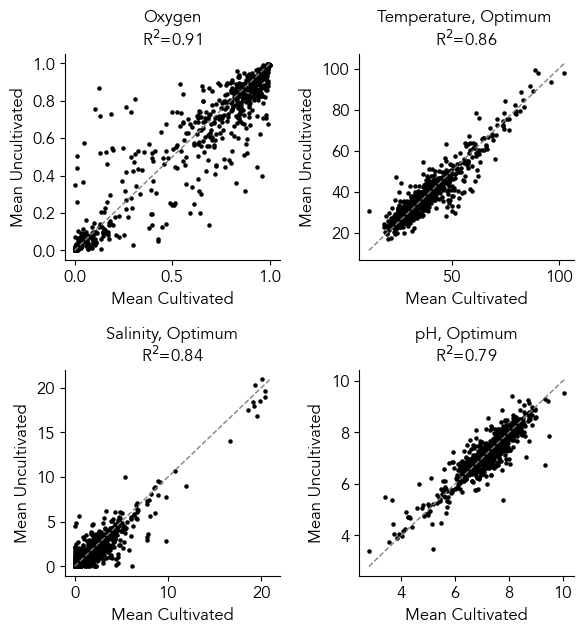

In [21]:
from sklearn.metrics import r2_score
target = 'salinity_optimum'

#fig, axes = plt.subplots(4,1,figsize=(3,13))
fig, axes = plt.subplots(2,2,figsize=(6,6.5))
axl = axes.flatten()

for n, target in enumerate(targets):
    ax = axl[n]
    df_plot = pd.pivot(df_compare, index='family', columns='is_isolate', values=target)
    


    xmin, xmax = df_plot.min().min(), df_plot.max().max()
    X = df_plot[True]
    Y = df_plot[False]

    #r = df_plot.corr(method='pearson').iloc[0,1]    
    r2 = r2_score(X,Y)
    ax.scatter(X, Y, s=5)
    ax.plot([xmin, xmax], [xmin,xmax], linestyle='--', color='gray')
    ax.set_title(plot_formats[target] + f'\nR$^2$={r2:.2f}')
    ax.set_xlabel('Mean Cultivated')
    ax.set_ylabel('Mean Uncultivated')
    
plt.tight_layout()


df_stats = df_sum.groupby('family').mean()
1 - np.mean(df_stats['n_isolate'] / df_stats['count']), 1 - np.min(df_stats['n_isolate'] / df_stats['count']), 1- np.max(df_stats['n_isolate'] / df_stats['count'])
plt.savefig("fig-3A.svg",  format="svg")
plt.show()

In [22]:

df_stats = df_sum.groupby('family').mean()
print("Average uncultivated fraction=", 1 - np.mean(df_stats['n_isolate'] / df_stats['count']))
print("Min uncultivated fraction=", 1 - np.min(df_stats['n_isolate'] / df_stats['count']))
print("Max uncultivated fraction=", 1 - np.max(df_stats['n_isolate'] / df_stats['count']))

Average uncultivated fraction= 0.6198985729450008
Min uncultivated fraction= 0.9974025974025974
Max uncultivated fraction= 0.005876591576885359


# Distribution

oxygen
temperature_optimum
salinity_optimum
ph_optimum


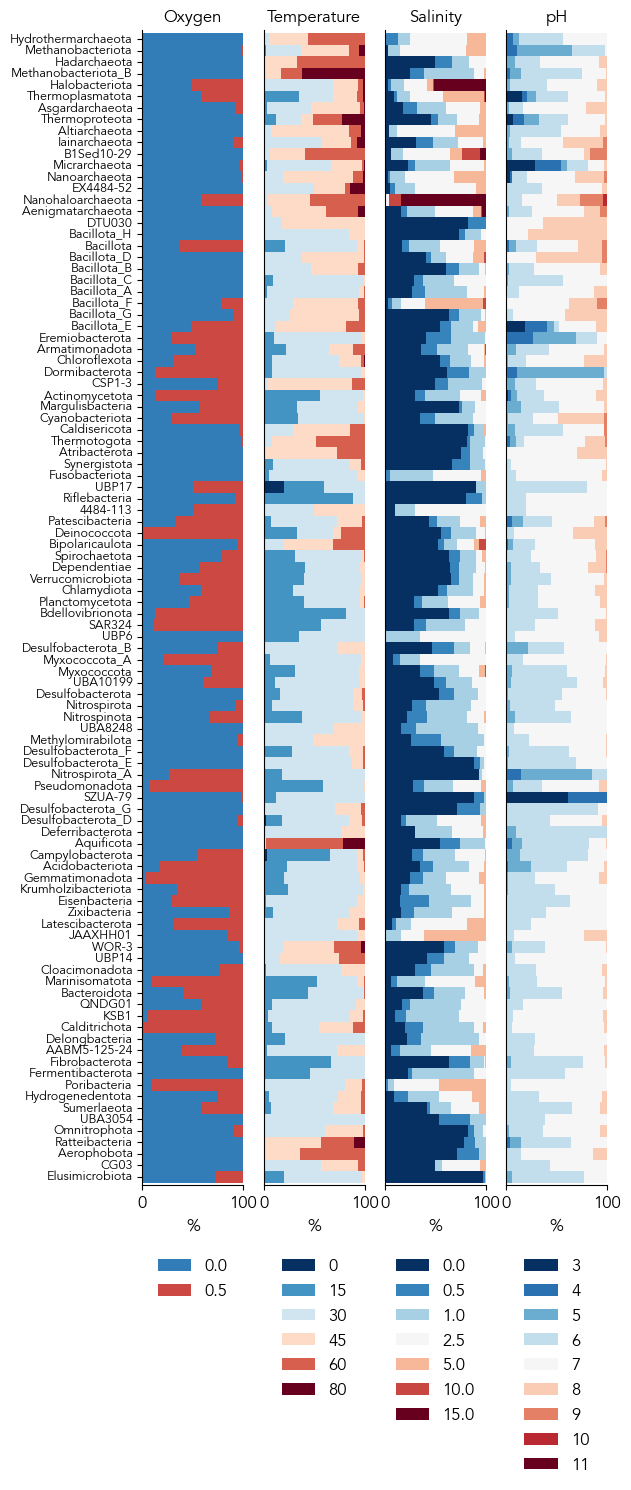

In [23]:
MIN_SPECIES_PER_PHYLUM = 10 

def distribution_df_by_target(target, df=df, taxonomic_level='phylum', normalize=True):
    
    sers = []
    bins = bin_definitions[target]
    for name, group in df.groupby(taxonomic_level):
        genome_ids = group.index.tolist()
        if len(genome_ids) > 0:
            values = df.reindex(genome_ids)[target].dropna()
            values.loc[values < bins[0]] = bins[0]
            binned_values = np.digitize(values, bins) - 1
            binned_ser = pd.Series(Counter(binned_values))
            binned_ser.name = name
            #binned_ser.index = range(len(bins) - 1)
            #binned_ser[0] = binned_ser.map(Counter(binned_values))
            sers.append(binned_ser)
    
    n_bins = len(bins) - 1
    blank_ser = pd.Series(dict(zip(range(n_bins), [0] * n_bins)))
    blank_ser.name = -1
    sers.append(blank_ser)
    
    dist_df = pd.DataFrame(sers).fillna(0).drop(-1)
    if normalize is True:
        dist_df = (dist_df.T / dist_df.sum(axis=1)).T
    dist_df = dist_df.T.sort_index().T
    return dist_df

fig, axes = plt.subplots(1,4, figsize=(6,15))

for n, target in enumerate(targets):
    ax = axes[n]
    dist_df = distribution_df_by_target(target, normalize=False)
    dist_df = dist_df[dist_df.sum(axis=1) >= MIN_SPECIES_PER_PHYLUM]
    dist_df = (dist_df.T / dist_df.sum(axis=1)).T
    dist_df = dist_df.reindex([f"p__{i}" for i in phylum_order if f"p__{i}" in dist_df.index])
    bins = bin_definitions[target]
    print(target)
    if target in ['oxygen',]:
        dist_df.columns = list(bins) #[:-1] 
        if target == 'oxygen':
            cmap = oxygen_cmap
        else:
            cmap = 'RdBu_r'
    else:
        dist_df.columns = list(bins)
        cmap = 'RdBu_r'

    (100 * dist_df).plot.barh(ax=ax, stacked=True, cmap=cmap, edgecolor='None', width=1, legend=True)
    ax.set_title(plot_formats[target.replace('_optimum', '')])
    if n == 0:
        ax.set_yticklabels([s[3:] for s in dist_df.index.tolist()], fontsize=9, rotation=0, ha='right', va='center')
        ax.legend(bbox_to_anchor=(1,0))
    else:
        ax.set_yticklabels([])
        ax.set_yticks([])

    #ax.set_xticks([0,0.5,1.])
    ax.set_xticks([0, 100])
    ax.set_xlim([0, 100])
    ax.set_xlabel('%')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.savefig("fig-3b.svg",  format="svg")
plt.show()

oxygen
temperature_optimum
salinity_optimum
ph_optimum


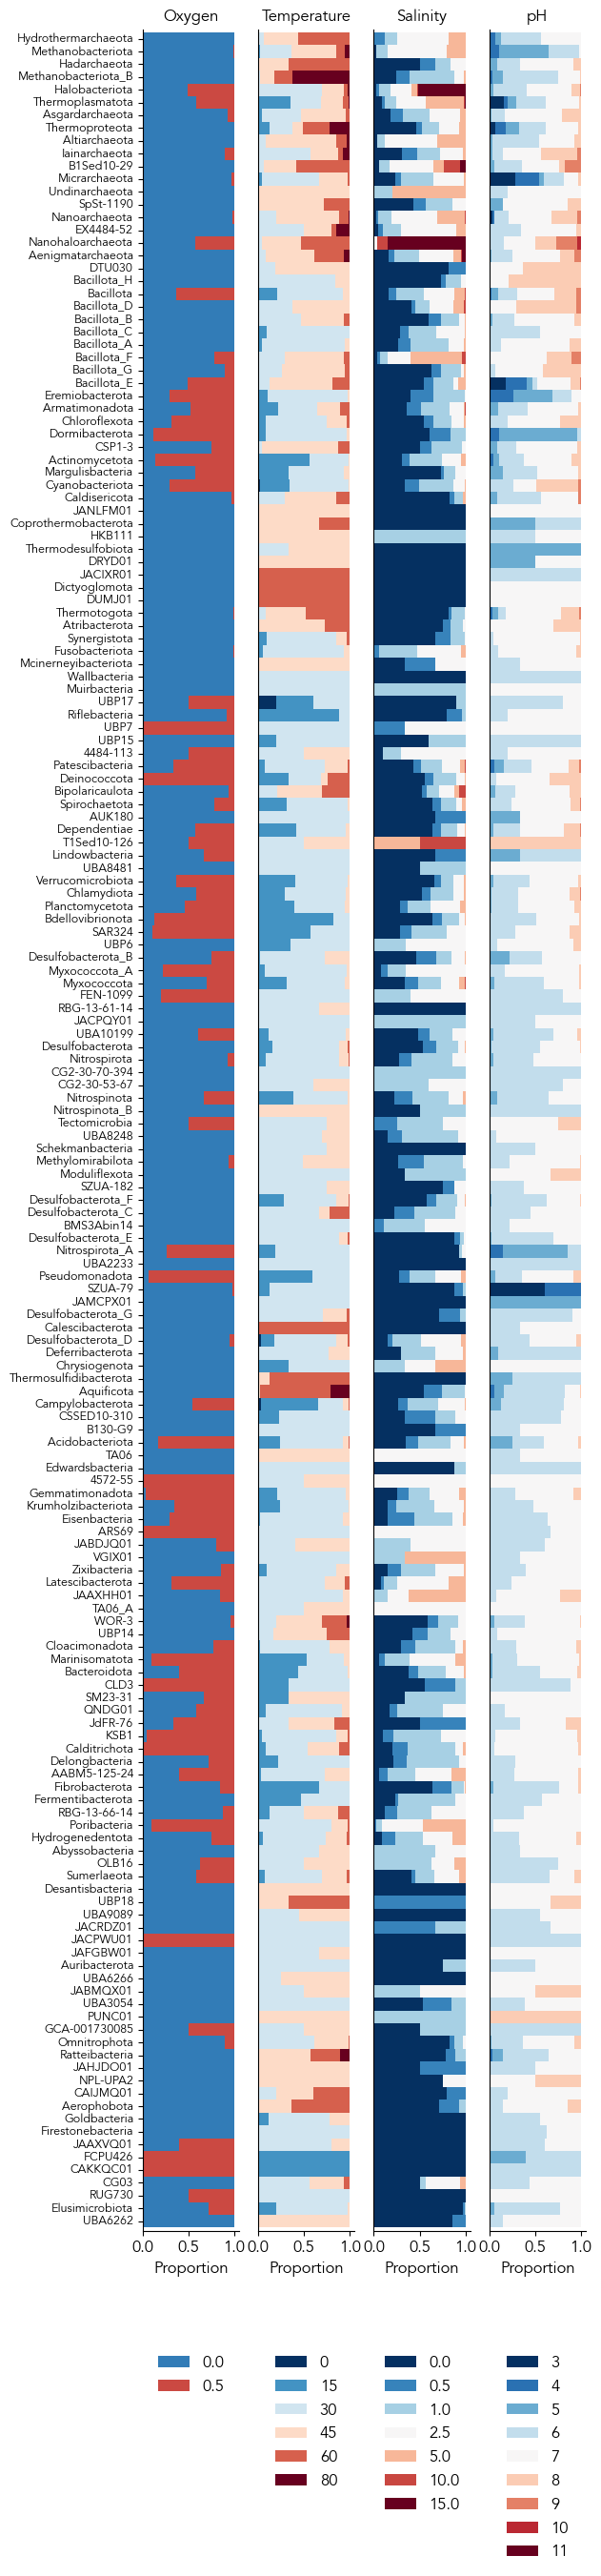

In [24]:
MIN_SPECIES_PER_PHYLUM = 1
fig, axes = plt.subplots(1,4, figsize=(6,30))

for n, target in enumerate(targets):
    ax = axes[n]
    dist_df = distribution_df_by_target(target, normalize=False)
    dist_df = dist_df[dist_df.sum(axis=1) >= MIN_SPECIES_PER_PHYLUM]
    dist_df = (dist_df.T / dist_df.sum(axis=1)).T
    dist_df = dist_df.reindex([f"p__{i}" for i in phylum_order if f"p__{i}" in dist_df.index])
    bins = bin_definitions[target]
    print(target)
    if target in ['oxygen',]:
        dist_df.columns = list(bins) #[:-1] 
        if target == 'oxygen':
            cmap = oxygen_cmap
        else:
            cmap = 'RdBu_r'
    else:
        dist_df.columns = list(bins)
        cmap = 'RdBu_r'

    dist_df.plot.barh(ax=ax, stacked=True, cmap=cmap, edgecolor='None', width=1, legend=True)
    ax.set_title(plot_formats[target.replace('_optimum', '')])
    if n == 0:
        ax.set_yticklabels([s[3:] for s in dist_df.index.tolist()], fontsize=9, rotation=0, ha='right', va='center')
        ax.legend(bbox_to_anchor=(1,0))
    else:
        ax.set_yticklabels([])
        ax.set_yticks([])

    ax.set_xticks([0,0.5,1.])
    ax.set_xlabel('Proportion')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False)

    

In [28]:
df[df['domain'] == 'd__Archaea']

,oxygen,ph_max,ph_min,ph_optimum,salinity_max,salinity_min,salinity_optimum,temperature_max,temperature_min,temperature_optimum,...,phylum,class,order,family,genus,species,ncbi_species,representative_ncbi_accession,accession,closest_isolate
GCA_020724205,0.037914,10.253015,6.076322,8.169805,12.140567,0.772290,5.908080,56.249439,38.611185,47.301461,...,p__Nanoarchaeota,c__Nanoarchaeia,o__Pacearchaeales,f__GW2011-AR1,g__JACPLR01,s__JACPLR01 sp020724205,,GCA_020724205,GB_GCA_020724205.1,class
GCA_023249725,0.016636,8.443092,4.068297,5.780223,7.265919,1.068360,2.026633,53.899764,27.160207,47.464078,...,p__Methanobacteriota,c__Methanobacteria,o__Methanobacteriales,f__Methanobacteriaceae,g__UBA349,s__UBA349 sp023249725,,GCA_023249725,GB_GCA_023249725.1,family
GCA_002495055,0.001526,8.527810,5.473961,6.760214,2.976090,1.735982,2.066294,44.474071,19.741216,37.768669,...,p__Halobacteriota,c__Methanomicrobia,o__Methanomicrobiales,f__Methanoregulaceae,g__Methanoregula,s__Methanoregula sp002495055,,GCA_002495055,GB_GCA_002495055.1,genus
GCA_002506825,0.659898,10.534040,5.411115,7.435787,15.603891,3.431805,7.093604,27.482555,3.142421,23.714241,...,p__Thermoplasmatota,c__Poseidoniia,o__Poseidoniales,f__Thalassarchaeaceae,g__MGIIb-O5,s__MGIIb-O5 sp002506825,,GCA_002506825,GB_GCA_002506825.1,phylum
GCA_001560915,0.000011,7.845766,5.273995,6.155724,3.137561,0.641282,1.910536,49.210825,30.824678,41.449778,...,p__Thermoplasmatota,c__Thermoplasmata,o__Methanomassiliicoccales,f__Methanomethylophilaceae,g__Methanomethylophilus,s__Methanomethylophilus sp001560915,,GCA_001560915,GB_GCA_001560915.1,species
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_013390375,0.034156,8.035911,5.866337,7.026867,4.569292,1.186407,2.316243,37.620976,18.537093,30.926521,...,p__Thermoproteota,c__Nitrososphaeria,o__Nitrososphaerales,f__Nitrosopumilaceae,g__Nitrosopelagicus,s__Nitrosopelagicus sp000484935,,GCA_013390375,GB_GCA_013390375.1,species
GCA_003602415,0.951123,9.714921,5.568166,6.915733,14.313956,3.030304,6.774084,27.827293,2.125591,24.518910,...,p__Thermoplasmatota,c__Poseidoniia,o__Poseidoniales,f__Poseidoniaceae,g__MGIIa-K1,s__MGIIa-K1 sp003602415,,GCA_003602415,GB_GCA_003602415.1,phylum
GCA_015522785,0.021881,7.330199,4.642423,5.609417,10.401368,0.408656,4.846594,67.577902,41.611833,58.475941,...,p__Nanoarchaeota,c__Nanoarchaeia,o__CSSed11-243R1,f__CSSed11-243R1,g__WALP01,s__WALP01 sp015522785,,GCA_015522785,GB_GCA_015522785.1,class
GCA_018220985,0.074233,9.742582,6.366331,8.253509,4.144502,0.000000,0.000000,54.141264,25.430893,46.564258,...,p__Nanoarchaeota,c__Nanoarchaeia,o__PEZQ01,f__PEZQ01,g__JAAOXS01,s__JAAOXS01 sp018220985,,GCA_018220985,GB_GCA_018220985.1,class


In [29]:
dist_df

,0.0,0.5


In [38]:
set(gtdb_df[gtdb_df['phylum'] == 'p__Aquificota']['ncbi_species'].tolist())

{'',
 'Aquifex aeolicus',
 'Balnearium lithotrophicum',
 'Desulfurobacterium atlanticum',
 'Desulfurobacterium indicum',
 'Desulfurobacterium thermolithotrophum',
 'Hydrogenivirga caldilitoris',
 'Hydrogenobacter hydrogenophilus',
 'Hydrogenobacter thermophilus',
 'Hydrogenothermus marinus',
 'Persephonella atlantica',
 'Persephonella hydrogeniphila',
 'Persephonella marina',
 'Phorcysia thermohydrogeniphila',
 'Sulfurihydrogenibium azorense',
 'Sulfurihydrogenibium subterraneum',
 'Sulfurihydrogenibium yellowstonense',
 'Thermocrinis albus',
 'Thermocrinis minervae',
 'Thermocrinis ruber',
 'Thermovibrio ammonificans',
 'Thermovibrio guaymasensis'}

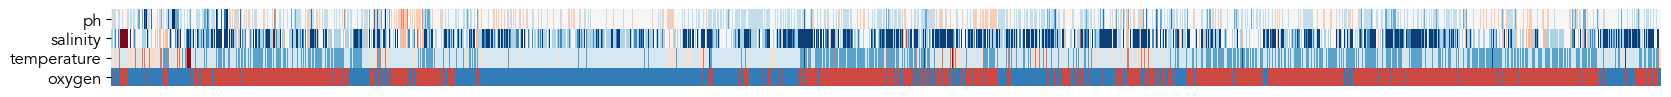

In [39]:
# Alt view  = plot of all species as heatmap
# Issue: some cells obscured / resolution too low
genome_data = df.sort_values(['domain', 'phylum', 'class','order','family','genus','species']) #.reindex(genome_ids)
C = []
for target in targets:
    bins = bin_definitions[target]
    X = genome_data[target].values
    X[X < bins[0]] = bins[0]
    ones = np.array([1] * len(X))
    X_binned = np.digitize(X, bins) / (len(bins)+1)
    C.append(X_binned)

fig, ax = plt.subplots(figsize=(20,1))
pcolor_kwargs = {
    'edgecolors' : 'None'
                }
ax.pcolor(range(len(C[0])), [0,2], [C[0], C[0]], cmap=oxygen_cmap, **pcolor_kwargs)#, edgecolor='black')#, edgecolor='white', lw=0.05)
ax.pcolor(range(len(C[0])), [2,4,6], C[1:], cmap='RdBu_r', **pcolor_kwargs)#,edgecolor='black')#, edgecolor='white', lw=0.05)
ax.set_yticks([i for i in range(8) if i % 2 == 0])
ax.set_yticklabels([target.split('_')[0] for target in targets])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([])
plt.show()

# Cultivation

In [31]:
training_df = pd.read_csv('../data/training_data/training_data.tsv', sep='\t', index_col=0)
training_df = training_df[['oxygen', 'ph_optimum', 'salinity_optimum', 'temperature_optimum']]

In [32]:
#mag_colors = ['steelblue', 'black', ]
cultivation_labels = ['All', 'Uncultivated', 'Cultivated', 'Uncultivated beyond Family', 'Uncultivated within Family']
#cultivation_labels = ['All', 'Uncultivated (All)', 'Cultivated', 'Uncultivated (Family+)', 'Uncultivated (Genus-Species)']
cultivation_colors = ['yellow', 'lightsteelblue', 'gray', 'black', 'orange']



is_isolate = (df['ncbi_genome_category'] == 'none')
is_novel_family = ~is_isolate & (~df['family'].isin(taxa_to_compare))
is_novel_genus = ~is_isolate & (df['family'].isin(taxa_to_compare))
cultivation_datasets = [df, df[~is_isolate], df[is_isolate], df[is_novel_family], df[is_novel_genus],
                        #df[~is_isolate & ~is_major], df[is_isolate & ~is_major], training_df.reindex(df[~is_major].index),
                       ]

for data_df, label in zip(cultivation_datasets, cultivation_labels + cultivation_labels):
    print(len(data_df)/len(df), label)
    

1.0 All
0.6810133735166698 Uncultivated
0.3189866264833302 Cultivated
0.2736037860237333 Uncultivated beyond Family
0.40740958749293654 Uncultivated within Family


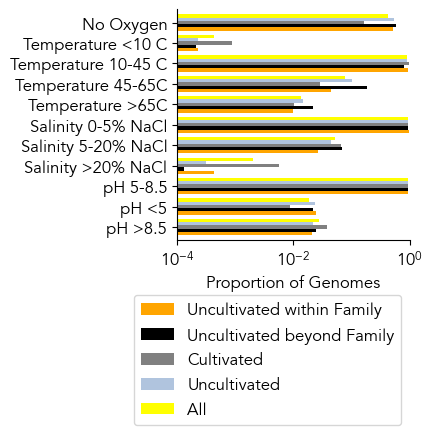

In [33]:

top_phyla = df['phylum'].value_counts().head(4).index
is_major = df['phylum'].isin(top_phyla)

is_anoxic = (df['oxygen'] <= 0.5)
indices = df[is_isolate & is_anoxic].index
# median_cysteine = df_features.loc[indices, 'all_aa_C'].dropna().median()
# genomes_above_median_cys =  df_features[df_features['all_aa_C'] > median_cysteine].index

data = {}
for data_df, label in zip(cultivation_datasets, cultivation_labels + cultivation_labels):
        
    is_anoxic = (data_df['oxygen'] <= 0.5)
    is_low_ph = (data_df['ph_optimum'] <= 5)
    is_high_ph = (data_df['ph_optimum'] >= 8.5)
    is_mod_ph = (data_df['ph_optimum'] > 5) & (data_df['ph_optimum'] < 8.5)
    is_low_temp = (data_df['temperature_optimum'] <= 10)
    is_mod_temp = (data_df['temperature_optimum'] >= 10) & (data_df['temperature_optimum'] < 45)
    is_high_temp = (data_df['temperature_optimum'] >= 45) & (data_df['temperature_optimum'] < 65)
    #is_any_high_temp = (data_df['temperature_optimum'] >= 45)
    is_extreme_temp = (data_df['temperature_optimum'] >= 65)
    is_low_salinity = (data_df['salinity_optimum'] < 5)
    is_mod_salinity = (data_df['salinity_optimum'] >= 5) & (data_df['salinity_optimum'] < 20)
    is_high_salinity = (data_df['salinity_optimum'] >= 20)
    #is_above_median_cys = np.array([idx in genomes_above_median_cys for idx in data_df.index])
    #any_extreme = (is_low_ph | is_high_ph | is_low_temp | is_high_temp | is_mod_salinity | is_high_salinity)

    n_genomes = len(data_df)

    data[label] = {
        'No Oxygen' : len(data_df[is_anoxic]) / np.sum(~data_df['oxygen'].isnull()),
        # f"No Oxygen & Cys>{100*median_cysteine:.1f}%" : len(data_df[is_anoxic & is_above_median_cys]) / np.sum(~data_df['oxygen'].isnull() & is_anoxic),
        # 'Any high temp' : len(data_df[is_any_high_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Temperature <10 C' : len(data_df[is_low_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Temperature 10-45 C' : len(data_df[is_mod_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Temperature 45-65C' :  len(data_df[is_high_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Temperature >65C' :  len(data_df[is_extreme_temp])/ np.sum(~data_df['temperature_optimum'].isnull()),
        'Salinity 0-5% NaCl' : len(data_df[is_low_salinity])/ np.sum(~data_df['salinity_optimum'].isnull()),
        'Salinity 5-20% NaCl' : len(data_df[is_mod_salinity])/ np.sum(~data_df['salinity_optimum'].isnull()),
        'Salinity >20% NaCl' :  len(data_df[is_high_salinity])/ np.sum(~data_df['salinity_optimum'].isnull()),
        'pH 5-8.5' :  len(data_df[is_mod_ph]) / np.sum(~data_df['ph_optimum'].isnull()),
        'pH <5' :  len(data_df[is_low_ph]) / np.sum(~data_df['ph_optimum'].isnull()),
        'pH >8.5' : len(data_df[is_high_ph])/ np.sum(~data_df['ph_optimum'].isnull()),

    }


fig, ax = plt.subplots(figsize=(3,3))
#pd.DataFrame(data)[::-1].T[::-1]
pd.DataFrame(data).T[::-1].T[::-1].plot.barh(ax=ax, 
                                           #color=['gray', 'cornflowerblue'],
                                           color=cultivation_colors[::-1], 
                                           width=0.8, edgecolor='None')
ax.set_xlim(1e-4,1)
ax.set_xscale('log')
ax.set_xlabel('Proportion of Genomes')
ax.legend(bbox_to_anchor=(1,-0.2))

In [34]:
# is_anoxic = (df['oxygen'] <= 0.5)
# indices = df[is_anoxic].index
# X = df_features.loc[indices, 'all_aa_C'].dropna()
# print(X.median())
# plt.hist(X, bins=50)

pH >8.5                0.583446
pH <5                  2.643943
pH 5-8.5               1.001144
Salinity >20% NaCl     0.054395
Salinity 5-20% NaCl    0.653701
Salinity 0-5% NaCl     1.030924
Temperature >65C       1.456113
Temperature 45-65C     3.484175
Temperature 10-45 C    0.921370
Temperature <10 C      0.253717
No Oxygen              3.291333
Name: Uncultivated / Cultivated, dtype: float64 0 Uncultivated

pH >8.5                0.547158
pH <5                  2.782430
pH 5-8.5               1.001288
Salinity >20% NaCl     0.075771
Salinity 5-20% NaCl    0.395783
Salinity 0-5% NaCl     1.049478
Temperature >65C       0.981541
Temperature 45-65C     1.549865
Temperature 10-45 C    0.984392
Temperature <10 C      0.260988
No Oxygen              3.125460
Name: Uncultivated within Family / Cultivated, dtype: float64 1 Uncultivated within Family

pH >8.5                0.637479
pH <5                  2.437730
pH 5-8.5               1.000930
Salinity >20% NaCl     0.022565
Salinity 5-2

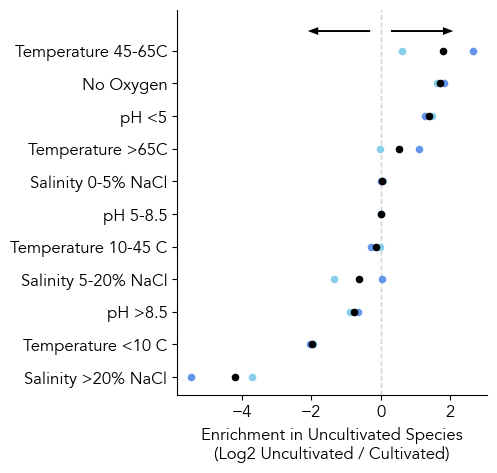

In [35]:
ratio_colors = ['black',  'skyblue', 'cornflowerblue']

fig, ax = plt.subplots(figsize=(4,5))
# 'Uncultivated beyond Family', 'Uncultivated within Family'
sers = []
for n, (numer, denom) in enumerate([('Uncultivated', 'Cultivated'),
                                    ('Uncultivated within Family', 'Cultivated'), 
                                    ('Uncultivated beyond Family', 'Cultivated')]):

    x = f"{numer} / {denom}"
    #fnumer = numer.replace(' ', '\n')
    label = numer.replace(' ', '\n')
    df_plot = pd.DataFrame(data)[::-1]
    df_plot[x] = df_plot[numer] / df_plot[denom]
    ser = df_plot[x]
    ser.name = x
    sers.append(ser)
    print(df_plot[x], n, numer)
    print()
    if n == 0:
        df_plot = df_plot.sort_values(x)
        indices = df_plot.index
    df_plot = df_plot.loc[indices]
    
    X = np.log2(df_plot[x])
    Y = range(len(X))
    
    ax.scatter(X,Y, color=ratio_colors[n], s=20, label=label, zorder=3-n)

ax.axvline(x=0, linestyle='--', color='lightgray', zorder=0)
ax.set_yticks(Y, df_plot[x].index)
#ax.set_xlim([-4,3])
ax.set_xlabel('Enrichment in Uncultivated Species\n(Log2 Uncultivated / Cultivated)')
#ax.legend(bbox_to_anchor=(0.5,-0.3), frameon=False, fontsize=11, loc='center')
#ax.legend(frameon=False, fontsize=11,bbox_to_anchor=(0.5,0.9),)
ax.arrow(-0.3, len(df_plot)-0.4, -1.5, 0, clip_on=False, width=0.06, head_width=0.24, head_length=0.3, lw=0, color='black')
ax.arrow(0.3, len(df_plot)-0.4, 1.5, 0, clip_on=False, width=0.06, head_width=0.24, head_length=0.3, lw=0, color='black')
plt.savefig("fig-3c.svg",  format="svg")
plt.show()

In [36]:
pd.DataFrame(data)

,All,Uncultivated,Cultivated,Uncultivated beyond Family,Uncultivated within Family
No Oxygen,0.416722,0.535680,0.162755,0.575879,0.508683
Temperature <10 C,0.000436,0.000225,0.000886,0.000215,0.000231
Temperature 10-45 C,0.908728,0.884646,0.960142,0.794544,0.945156
Temperature 45-65C,0.077486,0.100297,0.028787,0.183211,0.044615
Temperature >65C,0.013350,0.014832,0.010186,0.022030,0.009998
Salinity 0-5% NaCl,0.946635,0.955781,0.927111,0.930167,0.972982
Salinity 5-20% NaCl,0.051328,0.043908,0.067169,0.069704,0.026584
Salinity >20% NaCl,0.002037,0.000311,0.005720,0.000129,0.000433
pH 5-8.5,0.953946,0.954294,0.953203,0.954090,0.954431
pH <5,0.018930,0.023614,0.008931,0.021772,0.024850


In [61]:
df_ratios = pd.concat(sers,axis=1)
(df_ratios['Uncultivated beyond Family / Cultivated'] / df_ratios['Uncultivated within Family / Cultivated'])

pH >8.5                1.165072
pH <5                  0.876115
pH 5-8.5               0.999642
Salinity >20% NaCl     0.297810
Salinity 5-20% NaCl    2.622022
Salinity 0-5% NaCl     0.955995
Temperature >65C       2.203449
Temperature 45-65C     4.106459
Temperature 10-45 C    0.840649
Temperature <10 C      0.930656
No Oxygen              1.132097
dtype: float64

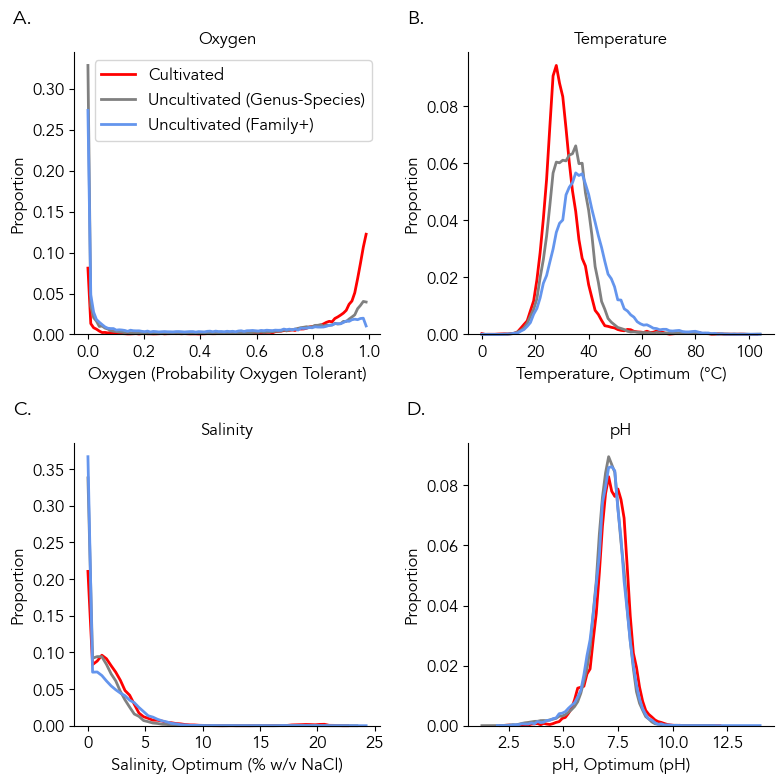

In [70]:
cultivation_labels = [ 'Cultivated',  'Uncultivated (Genus-Species)', 'Uncultivated (Family+)',]
cultivation_colors = ['red', 'gray', 'cornflowerblue', ]
cultivation_datasets = [df[is_isolate],  df[is_novel_genus], df[is_novel_family],]

def normalize_histogram(values, bins, norm = True):  
    digit_to_bin = dict(zip(range(1, len(bins)+1), list(bins) ))    
    binned_values = np.digitize(sorted(values), bins)
    counts = Counter(binned_values)
    if norm is True:
        counts = {k : v / len(binned_values) for k, v in counts.items()}
    
    binned_ser = pd.Series(counts).sort_index()
    X = binned_ser.index.map(digit_to_bin)
    Y = binned_ser.values
    return X, Y
    
fig, axes = plt.subplots(2,2,figsize=(8,8))
axl = axes.flatten()

conditions = ['oxygen', 'temperature', 'salinity', 'ph']
for n, condition in enumerate(conditions):
    x = rename_condition_to_variable(condition)
    for m, (df_plot, color, label) in enumerate(zip(cultivation_datasets, cultivation_colors, cultivation_labels)):
        ax = axl[n]
        data = df_plot[~df_plot[x].isnull()]

        X = data[f"{x}"].values
        if x == 'oxygen':
            bin_min, bin_max = 0, 1
        if x == 'salinity_optimum':
            bin_min, bin_max, bin_step = 0,40,0.25
        if x == 'ph_optimum':
            bin_min, bin_max, bin_step = 0, 14, 0.25
        if x == 'temperature_optimum':
            bin_min, bin_max, bin_step = 0,120,3

        bins = np.linspace(bin_min, bin_max, 100)
        X, Y = normalize_histogram(X, bins, norm=True,)
        
        ax.plot(X, Y, color=color, label=label,  clip_on=False, lw=2)
        ax.set_xlabel(f"{plot_formats[x]} ({units[condition]})")
        ax.set_ylabel('Proportion')
        ax.set_title(plot_formats[condition])
        #ax.set_yscale('log')
        if n == 0:
            ax.legend()
            
for n, ax in enumerate(axl):    
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.text(-0.2, 1.1, f"{string.ascii_uppercase[n]}.", transform=ax.transAxes,  size=14)

plt.tight_layout()

In [49]:
df[is_novel_family & (df['temperature_optimum'] > 45)][['phylum', 'class']].value_counts().head(20)

phylum                class              
p__Nanoarchaeota      c__Nanoarchaeia        578
p__Patescibacteria    c__Paceibacteria       410
p__Bacillota_A        c__Clostridia          245
p__Patescibacteria    c__ABY1                233
p__Chloroflexota      c__Anaerolineae        193
                      c__Dehalococcoidia     163
p__Omnitrophota       c__Koll11              148
p__Patescibacteria    c__Microgenomatia      126
p__Aenigmatarchaeota  c__Aenigmatarchaeia    121
p__Thermoplasmatota   c__Thermoplasmata      111
p__Thermoproteota     c__Bathyarchaeia       103
p__Bacillota          c__Bacilli             101
p__Micrarchaeota      c__Micrarchaeia         62
p__Asgardarchaeota    c__Lokiarchaeia         60
p__Bacillota_G        c__Limnochordia         56
p__Bacillota_D        c__Dethiobacteria       50
p__Acidobacteriota    c__Aminicenantia        49
p__Thermoplasmatota   c__E2                   49
p__Bacteroidota       c__Bacteroidia          45
p__Methylomirabilota  c__Me

In [50]:
df[is_novel_genus & (df['temperature_optimum'] > 45)][['family', 'genus']].value_counts().head(50)

family                        genus                    
f__Rikenellaceae              g__Alistipes                 65
f__Erysipelotrichaceae        g__Bulleidia                 28
                              g__UBA636                    26
f__Methanoculleaceae          g__Methanoculleus            20
f__Methanobacteriaceae        g__Methanobrevibacter_A      20
f__Lachnospiraceae            g__Acetatifactor             17
f__Methanomethylophilaceae    g__UBA71                     16
f__GWC2-37-13                 g__GWC2-37-13                15
f__Methanobacteriaceae        g__Methanobrevibacter        13
f__Lachnospiraceae            g__UBA3282                   12
f__Methanobacteriaceae        g__Methanobacterium_A        10
f__Methanoregulaceae          g__UBA9949                    9
f__Erysipelotrichaceae        g__RUG521                     9
f__Marinifilaceae             g__Odoribacter                9
f__Aquificaceae               g__Hydrogenivirga             9
f__Methanobact

## Some specifics

In [ ]:

df[df['genus'].str.contains("CAJXPB0")]
df[df['phylum'].str.contains("p__T1Sed10-126")] #.groupby('phylum')['salinity_optimum'] #.mean()
#df[df['family'].str.contains("f__PWEA01")].groupby('family')['salinity_optimum'].mean()
#np.mean(df[df['genus'] == 'g__Bifidobacterium']['oxygen'] > 0.5)

# Supplement

## More Distributions

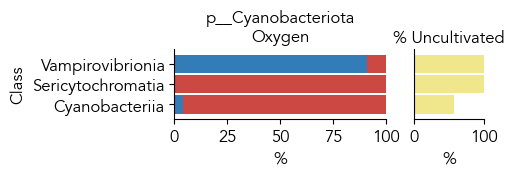

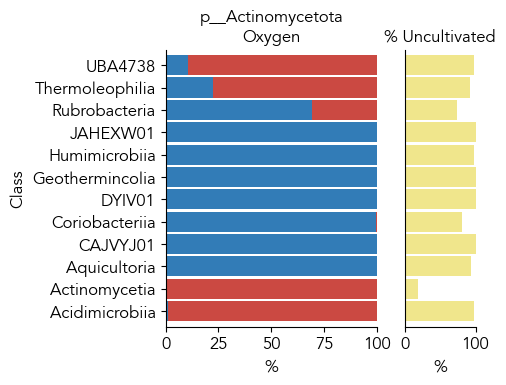

In [51]:
def plot_distribution_w_uncultivated(axes, dist_df, rank, taxon):
    

    ax = axes[0]
    bins = bin_definitions[target]
    if target in ['oxygen', 'ph_optimum']:
        #dist_df.columns = list(bins)
        #cmap = 'twilight'
        if target == 'oxygen':
            cmap = oxygen_cmap
        else:
            cmap = 'RdBu_r'
    else:
        dist_df.columns = list(bins)
        cmap = 'RdBu_r'
    
    dist_df.plot.barh(ax=ax, stacked=True, cmap=cmap, edgecolor='None', width=0.9, legend=False)
    ax.set_yticklabels([idx.replace('c__', '').replace('o__', '') for idx in dist_df.index])
    ax.set_ylabel(rank.capitalize())
    ax.set_title(taxon+'\n'+plot_formats[target])
    ax.set_xlabel('%')
    
    ax = axes[1]
    isolate_df = df[df[rank].isin(dist_df.index)].copy()
    isolate_df['is_isolate'] = (isolate_df['ncbi_genome_category'] == 'none')
    isolate_df = isolate_df[[rank, 'is_isolate']].value_counts().to_frame().reset_index()
    isolate_df = pd.pivot(isolate_df, index=rank, columns='is_isolate').fillna(0).rename(columns={False : 'Uncultivated', True : 'Cultivated'})
    #isolate_df = isolate_df[rank, 'is_isolate'].value_counts() #[targets].mean().reset_index()
    isolate_df = 100 *  (1-(isolate_df.T / isolate_df.sum(axis=1)).T)
    isolate_df = isolate_df.T[::-1].T
    isolate_df.plot.barh(ax=ax, stacked=True, color=['khaki', 'white'], edgecolor='None', width=0.9, legend=False)
    ax.set_yticks([])
    ax.set_title('% Uncultivated')
    ax.set_ylabel('')
    for ax in axes:
        ax.set_xlabel('%')
        ax.set_xlim([0,100])
    return  axes
    
for taxon in ['p__Cyanobacteriota', 'p__Actinomycetota']: #, 'p__Asgardarchaeota',]:
    rank = 'class'
    target = 'oxygen'
    dist_df = distribution_df_by_target(target, df=df[df['phylum'] == taxon], taxonomic_level=rank, normalize=True)
    dist_df = 100 * dist_df

    fig, axes = plt.subplots(1,2, figsize=(4,0.3*dist_df.shape[0]), gridspec_kw={'width_ratios' : (3,1)})

    axes = plot_distribution_w_uncultivated(axes, dist_df, rank, taxon)


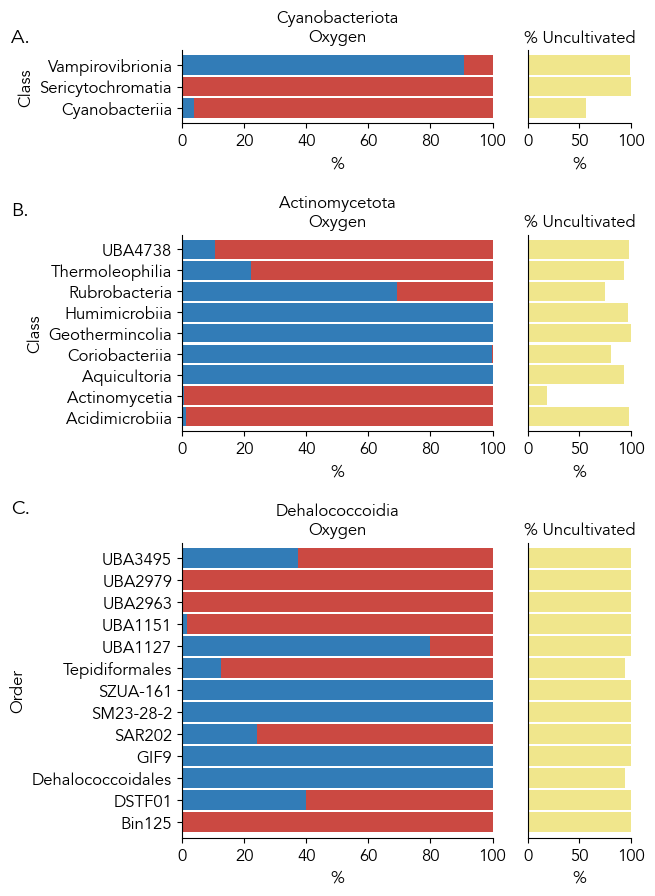

In [68]:
import string

abbrev_to_level = {'p' : 'phylum', 'c' : 'class'}
fig, axes = plt.subplots(3,2, figsize=(7,0.7*dist_df.shape[0]), gridspec_kw={'width_ratios' : (3,1), 'height_ratios' : (3,8,12)})

rank = 'order'
for n, (taxon, target, rank) in enumerate([
    ('p__Cyanobacteriota', 'oxygen', 'class' ),
    ('p__Actinomycetota', 'oxygen', 'class'),
    ('c__Dehalococcoidia', 'oxygen', 'order'),
                   #   ('p__Eremiobacterota', 'ph_optimum', 'class'),
                     ]):

    
    level = abbrev_to_level[taxon.split('__')[0]]
    dist_df = distribution_df_by_target(target, df=df[df[level] == taxon], taxonomic_level=rank, normalize=False)
    
    dist_df = dist_df[dist_df.sum(axis=1) >= 10]
    dist_df = (dist_df.T / dist_df.sum(axis=1)).T
    dist_df = 100 * dist_df
    
    

    plot_distribution_w_uncultivated(axes[n], dist_df, rank, taxon.replace('p__', '').replace('c__', ''))
    ax = axes[n][0]
    ax.text(-0.55, 1.1, f"{string.ascii_uppercase[n]}.", transform=ax.transAxes,  size=14)


plt.tight_layout(pad=1)

## Novel 

In [ ]:
#for target, genomes in novel_for_target.items():

target = 'salinity_optimum'
novel_genomes = novel_for_target[target]

novel_counts = df.loc[novel_genomes]['phylum'].value_counts()
novel_counts.name = 'novel'

counts = df['phylum'].value_counts()
counts.name = 'all'

novel_df = pd.concat([counts, novel_counts], axis=1)
novel_df['fraction'] = novel_df['novel'] / novel_df['all']
novel_df[novel_df['all'] >= 10].sort_values('fraction', ascending=False).head(20)

## Min > Max

In [92]:
for n, condition in enumerate(['temperature', 'ph', 'salinity']):

    x = f'{condition}_min'
    y = f'{condition}_max'
    z = f'{condition}_optimum'

    filter = (optima_df[z] > optima_df[y]) | (optima_df[x] > optima_df[y])
    print(condition, np.sum(filter) / len(optima_df))

temperature 0.00023544923714447166
ph 0.0005179883217178376
salinity 0.05404737238651347


In [55]:
np.sum(filter), len(optima_df)

(4591, 84944)

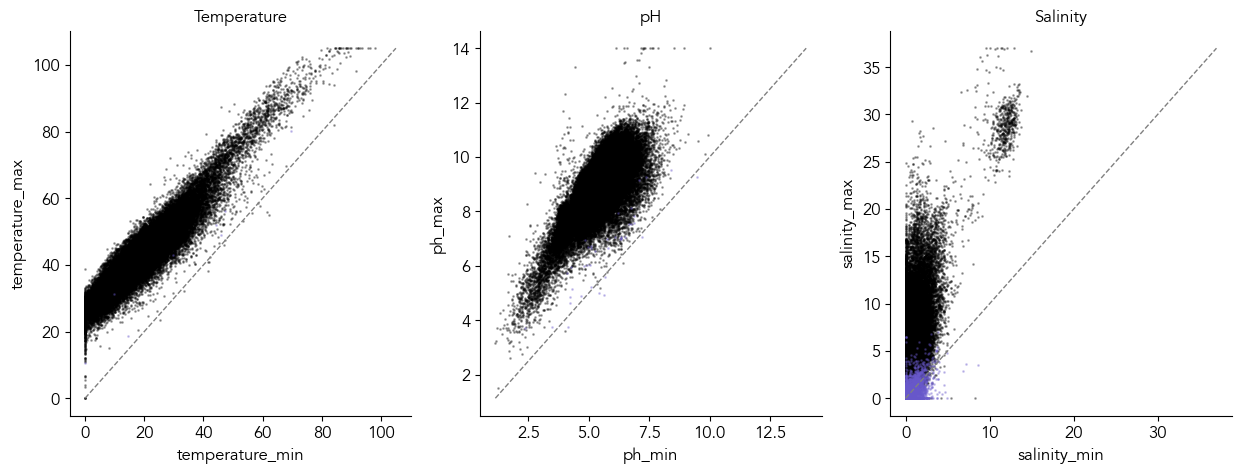

In [56]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

for n, target_type in enumerate(['temperature', 'ph', 'salinity']):
    ax = axes[n]
    x = f'{target_type}_min'
    y = f'{target_type}_max'
    z = f'{target_type}_optimum'

    filter = optima_df[z] > optima_df[y]
    X = optima_df[x].values
    Y = optima_df[y].values
    ax.scatter(X[~filter], Y[~filter], s=1, alpha=0.3)
    ax.scatter(X[filter], Y[filter], s=1, alpha=0.3)
    ax.plot([X.min(), Y.max()], [X.min(), Y.max()], linestyle='--', color='gray')
    ax.set_title(plot_formats[target_type])
    ax.set_xlabel(x)
    ax.set_ylabel(y)


In [57]:
target_type = 'salinity'
x = f'{target_type}_min'
y = f'{target_type}_max'
z = f'{target_type}_optimum'
print(len(optima_df[(optima_df[y] <= optima_df[x]) | (optima_df[y] <= optima_df[z]) ]) / len(optima_df[~optima_df[y].isnull()]))
#print(len(optima_df[optima_df[y] < optima_df[z]]) / len(optima_df[~optima_df[y].isnull()]))
df.loc[optima_df[optima_df[y] < optima_df[x]].index, ['class']].value_counts().head(50)

0.13481823318892447


class                    
c__Clostridia                724
c__Cyanobacteriia            285
c__Bacilli                   213
c__Bacteroidia               181
c__Vampirovibrionia          121
c__Gammaproteobacteria        71
c__Polyangia                  57
c__Planctomycetia             55
c__Thermodesulfovibrionia     51
c__Campylobacteria            51
c__Alphaproteobacteria        49
c__Paceibacteria              45
c__Aquificae                  45
c__Microgenomatia             36
c__Eremiobacteria             33
c__Nitrososphaeria            33
c__Leptospirae                33
c__Coriobacteriia             28
c__Kapabacteria               28
c__ABY1                       28
c__Myxococcia                 26
c__Dehalococcoidia            26
c__Blastocatellia             26
c__Methanomicrobia            23
c__Terriglobia                23
c__Actinomycetia              22
c__Spirochaetia               20
c__MSB-5A5                    19
c__UBA9042                    18
c__Desulfuromonad

In [58]:
df[df['genus'] == 'g__Pelagibacter'][['salinity_optimum', 'salinity_max']].describe() 

,salinity_optimum,salinity_max
count,855.000000,855.000000
mean,2.918425,9.469423
std,1.046429,2.212730
min,0.000000,0.000000
25%,2.292804,8.184979
50%,2.984039,9.710589
75%,3.547561,10.900442
max,6.978365,15.735947


In [59]:
taxlevels = ['family', 'phylum']
ser_some = df.loc[optima_df[optima_df[y] <= optima_df[x]].index, taxlevels].value_counts()
ser_some.name = 'filtered'
ser_all = df.loc[:, taxlevels].value_counts()
ser_all.name = 'all'

counts_df = pd.concat([ser_some, ser_all], axis=1)
counts_df['f_filtered'] = counts_df['filtered'] / counts_df['all']
counts_df.loc[counts_df['all'] > 5].sort_values('f_filtered', ascending=False).head(30).style.background_gradient(cmap='Blues')

,,filtered,all,f_filtered
family,phylum,,,
f__JABDFU01,p__Bacteroidota,6.000000,6,1.000000
f__Ammonificaceae,p__Bacillota_B,6.000000,6,1.000000
f__Pluralincolimonadaceae,p__Omnitrophota,7.000000,7,1.000000
f__Velamenicoccaceae,p__Omnitrophota,7.000000,7,1.000000
f__Chlamydiaceae,p__Chlamydiota,23.000000,23,1.000000
f__CAITNM01,p__Pseudomonadota,7.000000,7,1.000000
f__Thermodesulfatatoraceae,p__Desulfobacterota,7.000000,7,1.000000
f__HRBIN17,p__Armatimonadota,7.000000,7,1.000000
f__Gloeobacteraceae,p__Cyanobacteriota,6.000000,6,1.000000


## Genomes with Oxygen but without Other Predictions

In [85]:
missing_df = gtdb_df.set_index('ncbi_accession').loc[missing_genomes]
missing_df['checkm_completeness'].describe()

count    259.000000
mean      91.072355
std       12.977636
min       18.130000
25%       88.540000
50%       96.340000
75%       98.780000
max      100.000000
Name: checkm_completeness, dtype: float64

In [90]:
missing_df['genus'].value_counts().head(20)

genus
g__Blattabacterium     44
g__Buchnera            41
g__GCA-012562765       18
g__Blochmannia         12
g__Stammera            12
g__Phytoplasma          8
g__Streptomyces         5
g__SoEE                 4
g__Nardonella           4
g__Sphingomonas         3
g__Wolbachia            3
g__Pseudorhodoferax     3
g__Westeberhardia       2
g__Tremblaya            2
g__Ehrlichia            2
g__Methanoperedens      2
g__Sulcia               2
g__Amycolatopsis        2
g__RUG11194             2
g__Rubrivivax           2
Name: count, dtype: int64

In [134]:
#np.percentile(df_features['all_total_proteins'], 2.7)
X = df_features['all_total_proteins']
np.percentile(X, 1)

636.0

In [116]:
df_features.loc[missing_genomes]['all_total_proteins'].describe(percentiles=[.50,.60,.70,.75,.80])

count      259.000000
mean      1847.343629
std       2601.369421
min        198.000000
50%        584.000000
60%        596.800000
70%        694.400000
75%       1804.500000
80%       3663.400000
max      12087.000000
Name: all_total_proteins, dtype: float64

In [119]:
100 * (1 - len(missing_genomes) / len(gtdb_df[gtdb_df['gtdb_representative'] == 't']))

99.69602722844904

In [135]:
len(gtdb_df[gtdb_df['gtdb_representative'] == 't'])

85205